# Description 


**Author**: Felipe Matheus <br>
**Start Date**: 16/01/2023 <br>
**End Date**: --/01/2023 <br>
**Related Links**: stackoverflow.com



**Objective** 

The objective of this notebook is to model...



# Setup

Modules dockerized NB

In [ ]:
# import os
# import sys
# import numpy as np
# import matplotlib.pyplot as plt

# from src.visualization.Plots import Plots
# from src.metrics.Evaluations import Evaluations
# from src.processing.Processing import Processing
# from config.Variables import Variables
# from src.DataLoader import DataLoader

# %load_ext autoreload
# %autoreload 2


Modules without dockerized NB

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.visualization.Plots import Plots
from src.metrics.Evaluations import Evaluations
from src.processing.Processing import Processing
from config.Variables import Variables
from src.DataLoader import DataLoader

%load_ext autoreload
%autoreload 2

In [ ]:
varv = Variables()

plot = Plots()
eval = Evaluations()
proc = Processing()
load = DataLoader(varv.PATH_DATA_STRUCTURED)


# Loading files

In [ ]:
am_ints = np.load(load.folder_path + "Am241_int.npy")
am_peak = np.load(load.folder_path + "Am241_peak.npy")
am_spec = np.load(load.folder_path + "Am241_spectreraies.npy")


FileNotFoundError: [Errno 2] No such file or directory: '../../data/raw//Am241_int.npy'

**Author**: Felipe Matheus <br>
**Start Date**: 05/01/2023 <br>
**End Date**: /01/2023 <br>


***

**Objective** 

The objective of this notebook is to use the data processed to develop interpolation models for detector's response.

# Setup

Libs

In [3]:
import os
import sys
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Modules

In [26]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing.Processing import Processing
from src.processing.DataDumper import DataDumper
from src.processing.DataLoader import DataLoader
from src.modeling.nn.NN import Interpolater
from config.Variables import Variables
from src.utils import verify_gpu, verify_number_gpus

varv = Variables()
load_ex = DataLoader(varv.EX_DATA_FILE_PATH)
dump = DataDumper()
proc = Processing()



In [5]:
nn = Interpolater(name=varv.HYPERPARAMETERS.name
                  learning_rate=varv.HYPERPARAMETERS.learning_rate)


c:\projects\detector-response-interpolation\.detector-response-interpolation2\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Loading and verifying

In [6]:
ranges = np.arange(varv.RESPONSE_MATRIX_FIRST_KEV,
                   varv.RESPONSE_MATRIX_LAST_KEV+varv.RESPONSE_MATRIX_BIN_SIZE,
                   varv.RESPONSE_MATRIX_BIN_SIZE)

real_ranges = np.arange(0,
                        varv.RESPONSE_MATRIX_LAST_KEV+varv.RESPONSE_MATRIX_BIN_SIZE,
                        varv.RESPONSE_MATRIX_BIN_SIZE)

files_list = [np.load(varv.PATH_STRUCTURED_DATA+f"{energy_value}keV_spectrum.npy")
              for energy_value in ranges]

response_matrix, amount_photons = proc.get_response_matrix(files_list=files_list, first_kev=varv.RESPONSE_MATRIX_FIRST_KEV,
                                                           last_kev=varv.RESPONSE_MATRIX_LAST_KEV,
                                                           bin_size=varv.RESPONSE_MATRIX_BIN_SIZE)


# PreProcessing data

In [15]:
response_matrix_norm = np.zeros(shape=(varv.RESPONSE_MATRIX_DIM, varv.RESPONSE_MATRIX_DIM))
norm_factor = np.max(response_matrix, axis=1)
response_matrix_norm[norm_factor>0] =  np.divide(response_matrix[norm_factor>0], norm_factor[norm_factor>0][:,None])

In [19]:
E0 = np.arange(varv.RESPONSE_MATRIX_DIM)/2
E1 = np.arange(varv.RESPONSE_MATRIX_DIM)/2

flatten_intensities = response_matrix_norm.flatten()

In [22]:
E_train = np.zeros((np.size(flatten_intensities), 2))

Evecvec_dep, Evecvec_source = np.meshgrid(np.arange(varv.RESPONSE_MATRIX_DIM)/2, np.arange(varv.RESPONSE_MATRIX_DIM)/2)

E_train[:, 0] = Evecvec_source.flatten()
E_train[:, 1] = Evecvec_dep.flatten()

In [28]:
verify_gpu()
verify_number_gpus()

Default GPU Device: /device:GPU:0
Num GPUs Available:  1


In [23]:
nn.model.fit(E_train/varv.RESPONSE_MATRIX_LAST_KEV, flatten_intensities,
             epochs=varv.HYPERPARAMETERS.num_epochs,
             batch_size=varv.RESPONSE_MATRIX_DIM)


Epoch 1/20
4001/4001 [==============================] - 97s 23ms/step - loss: 0.0124
Epoch 2/20
4001/4001 [==============================] - 60s 15ms/step - loss: 0.0052
Epoch 3/20
4001/4001 [==============================] - 59s 15ms/step - loss: 0.0038
Epoch 4/20
4001/4001 [==============================] - 95s 24ms/step - loss: 0.0037
Epoch 5/20
4001/4001 [==============================] - 93s 23ms/step - loss: 0.0036
Epoch 6/20
4001/4001 [==============================] - 94s 23ms/step - loss: 0.0036
Epoch 7/20
4001/4001 [==============================] - 94s 23ms/step - loss: 0.0036
Epoch 8/20
4001/4001 [==============================] - 93s 23ms/step - loss: 0.0035
Epoch 9/20
4001/4001 [==============================] - 93s 23ms/step - loss: 0.0035
Epoch 10/20
4001/4001 [==============================] - 92s 23ms/step - loss: 0.0034
Epoch 11/20
4001/4001 [==============================] - 92s 23ms/step - loss: 0.0033
Epoch 12/20
4001/4001 [==============================] - 93s 23

In [29]:
nn.model.save(f'{varv.PATH_MODELS}/interpolator')

INFO:tensorflow:Assets written to: ../../models//interpolator\assets


126/126 [==============================] - 1s 4ms/step


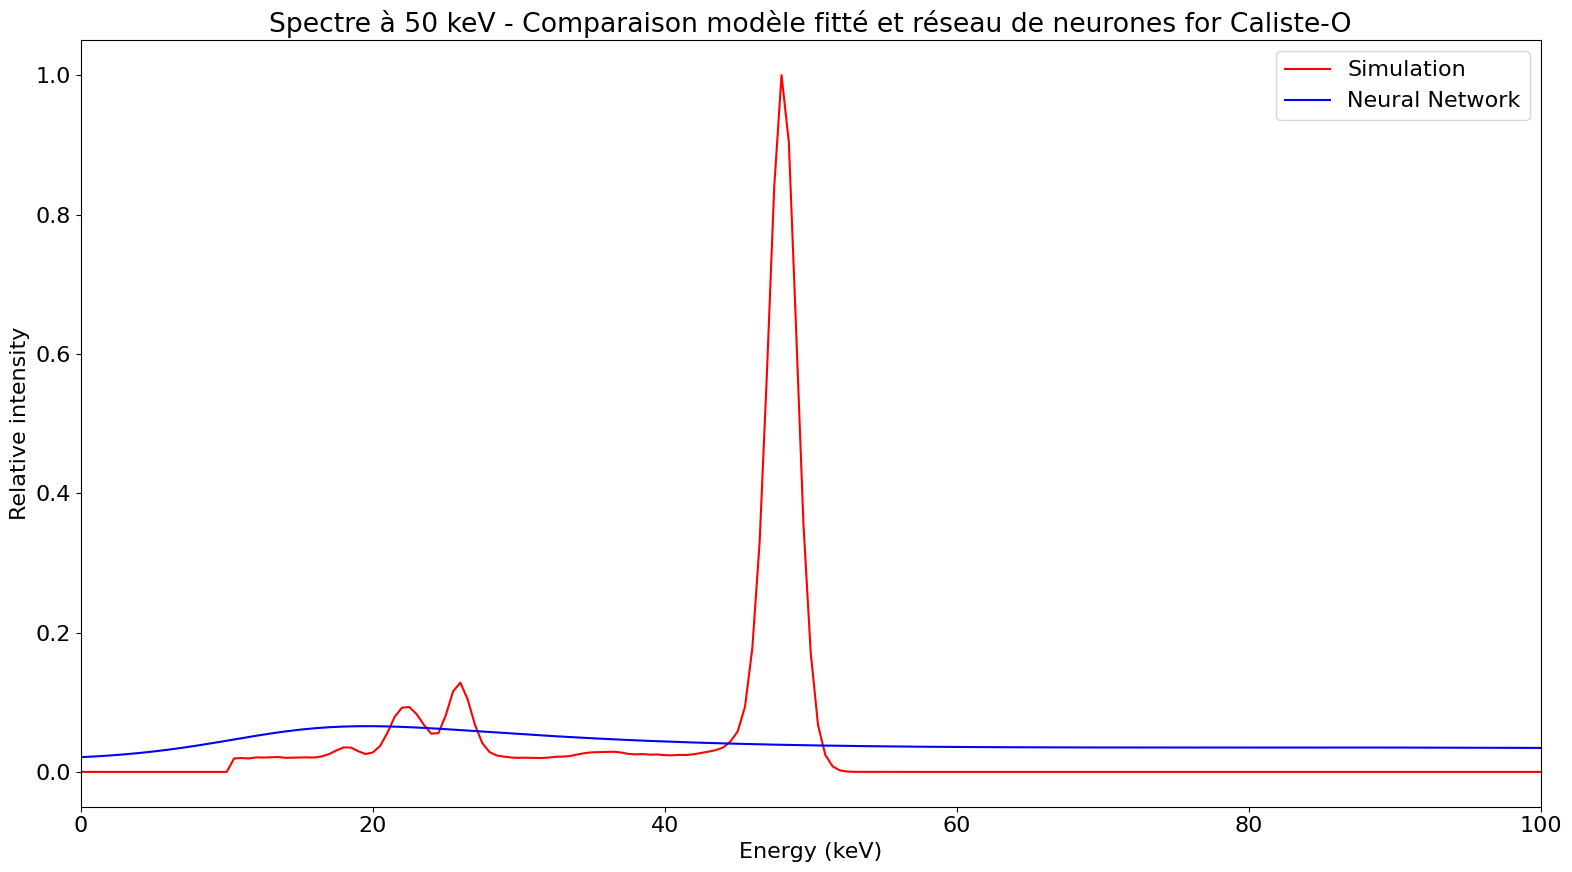

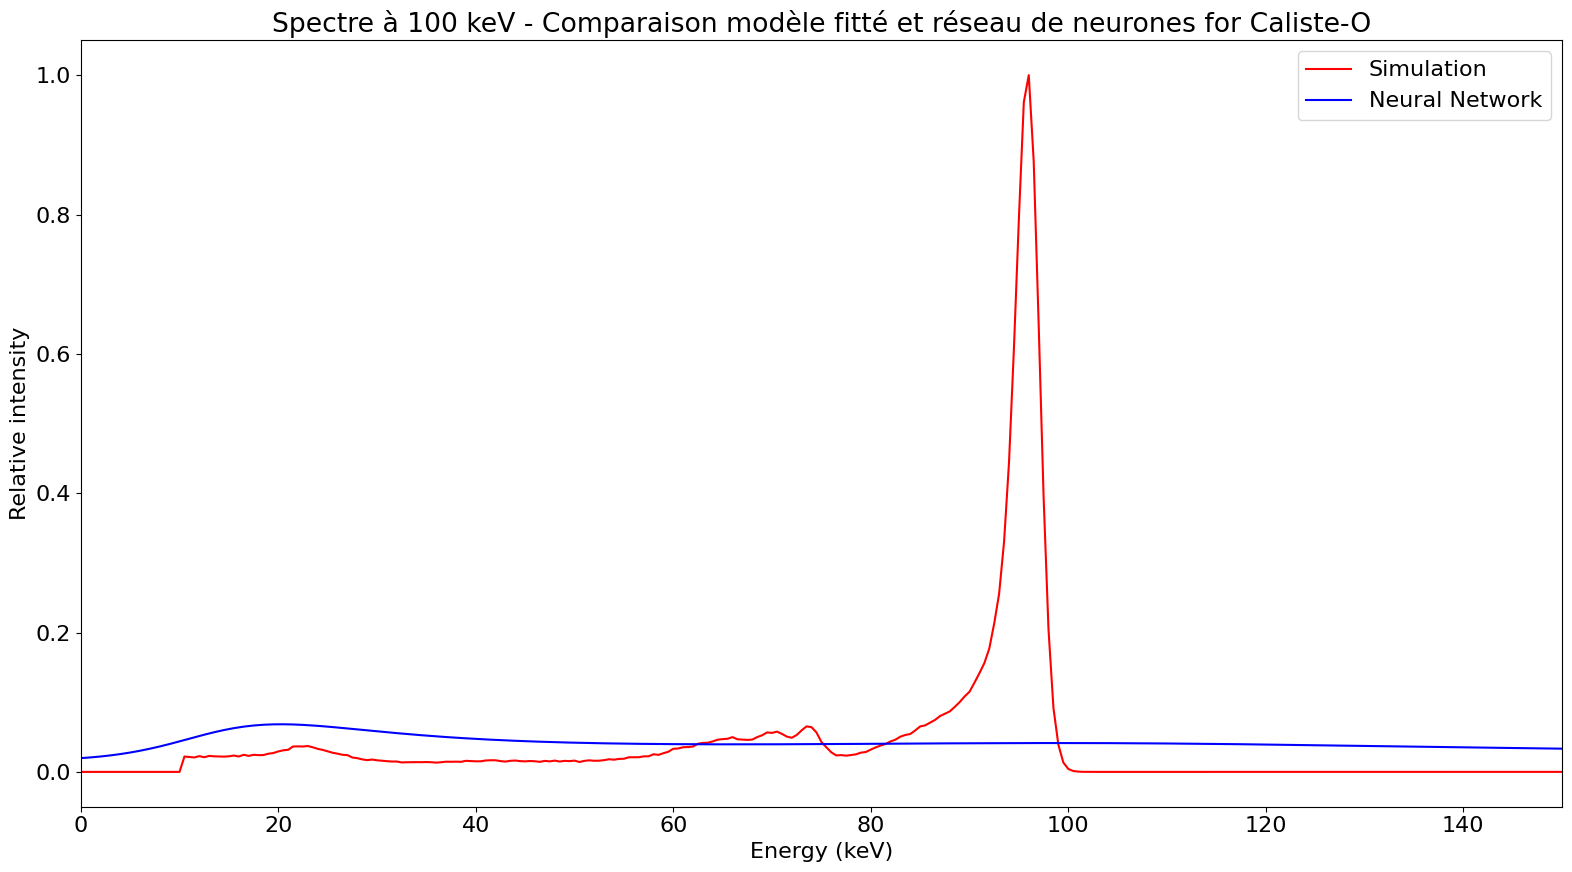

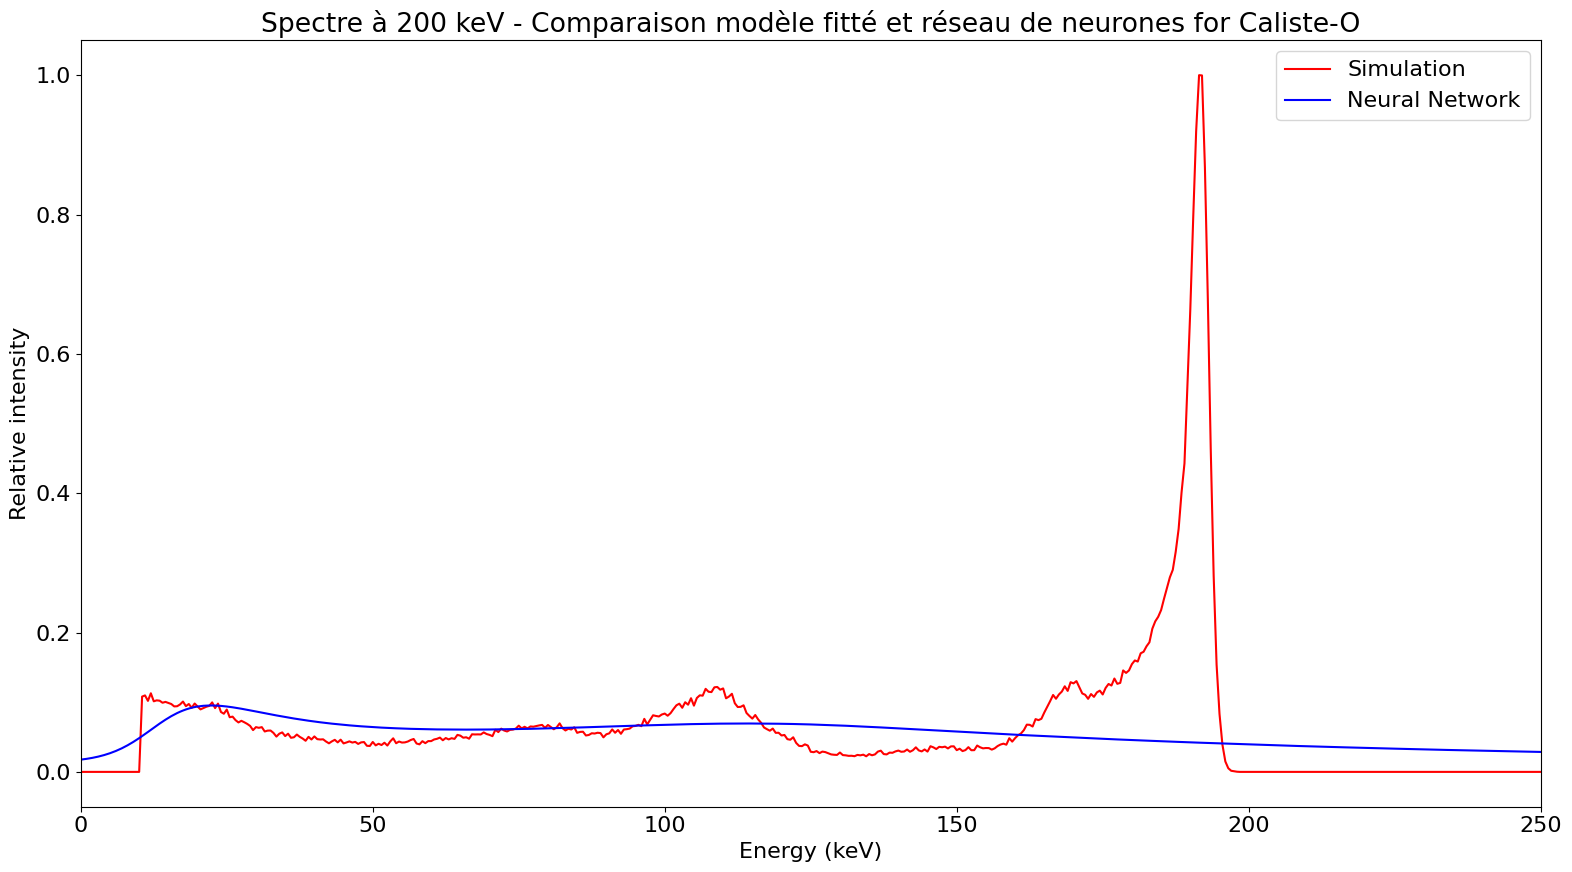

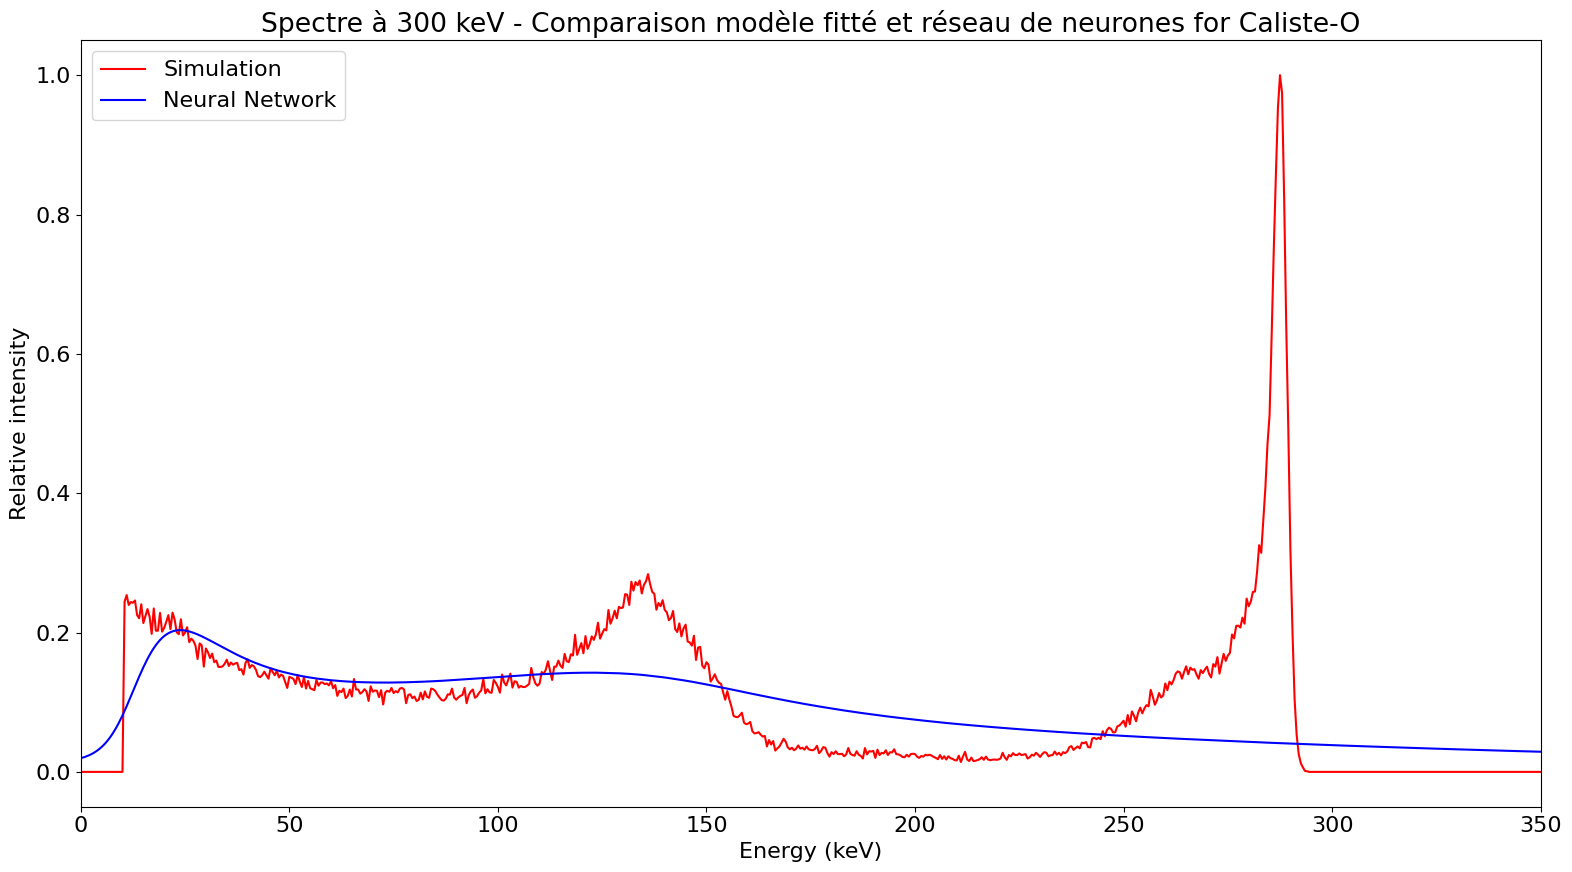

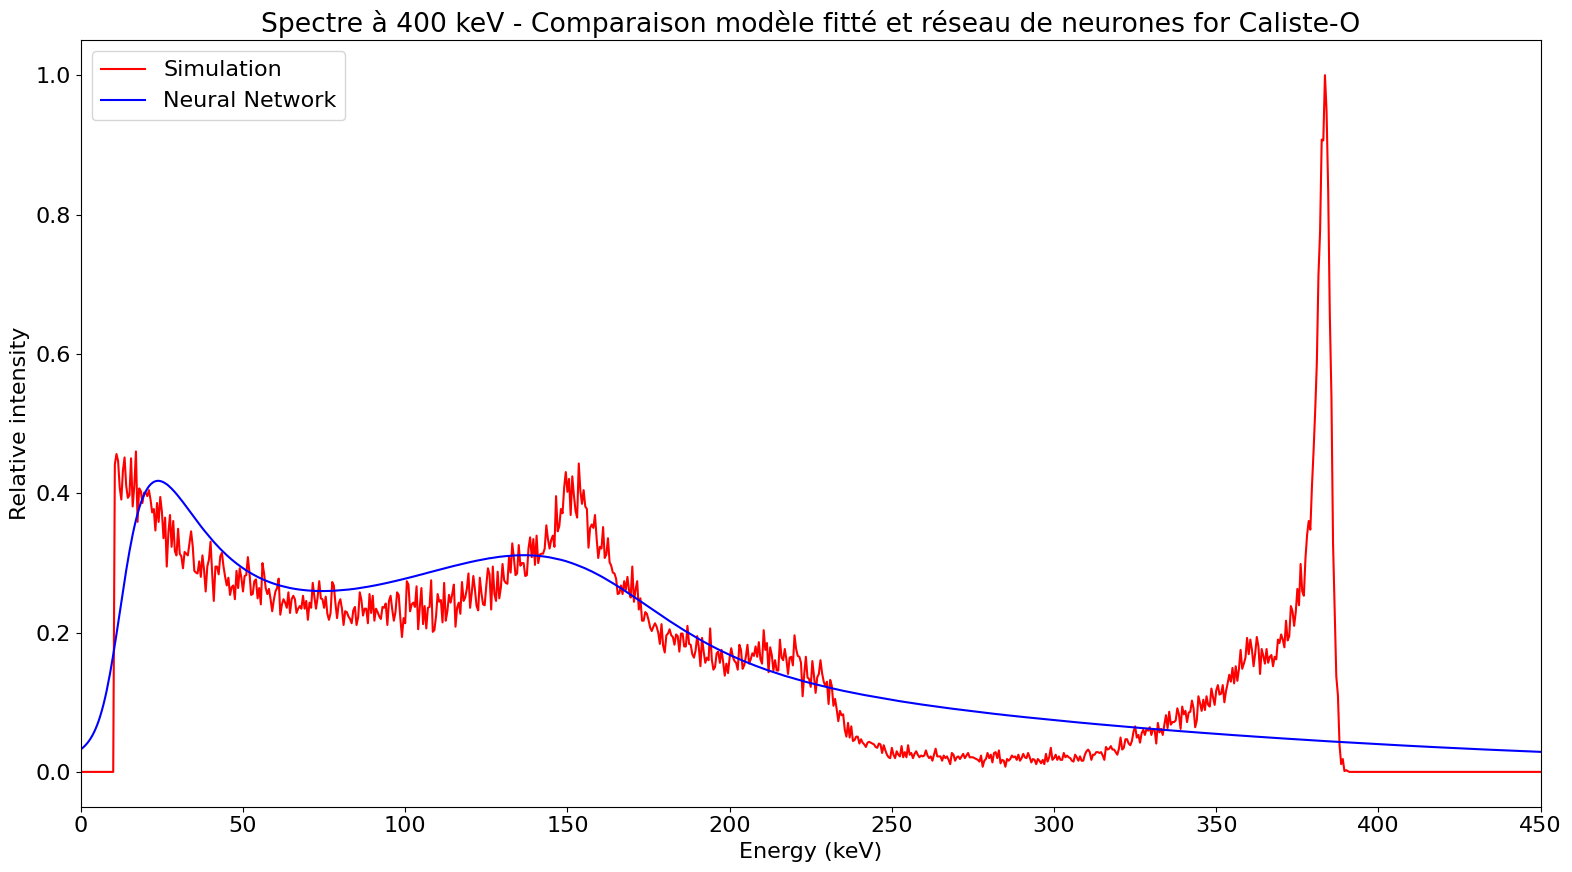

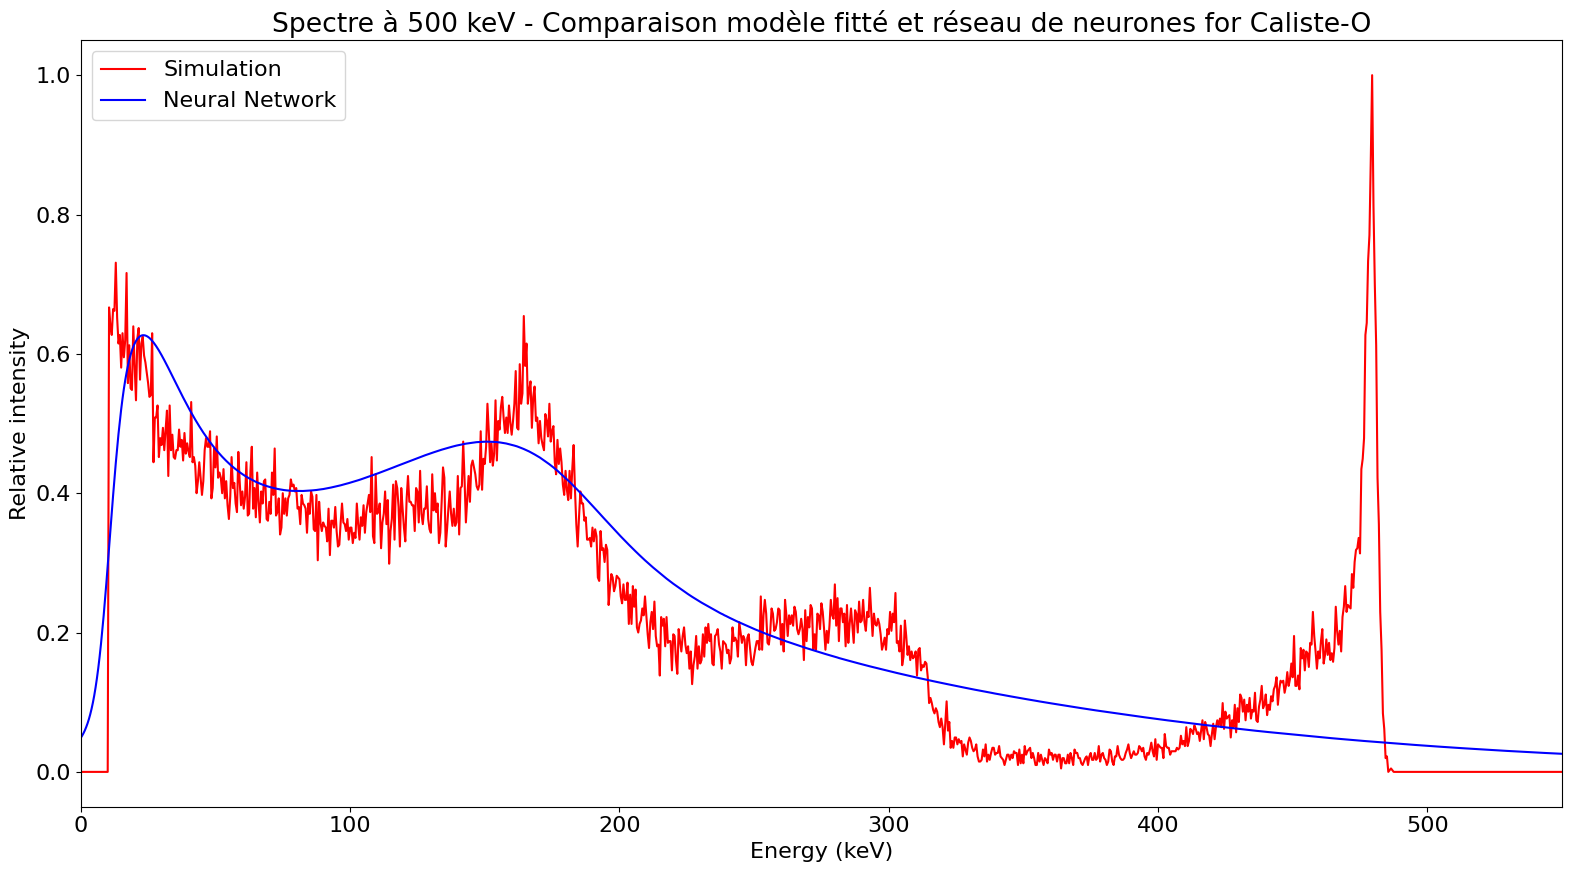

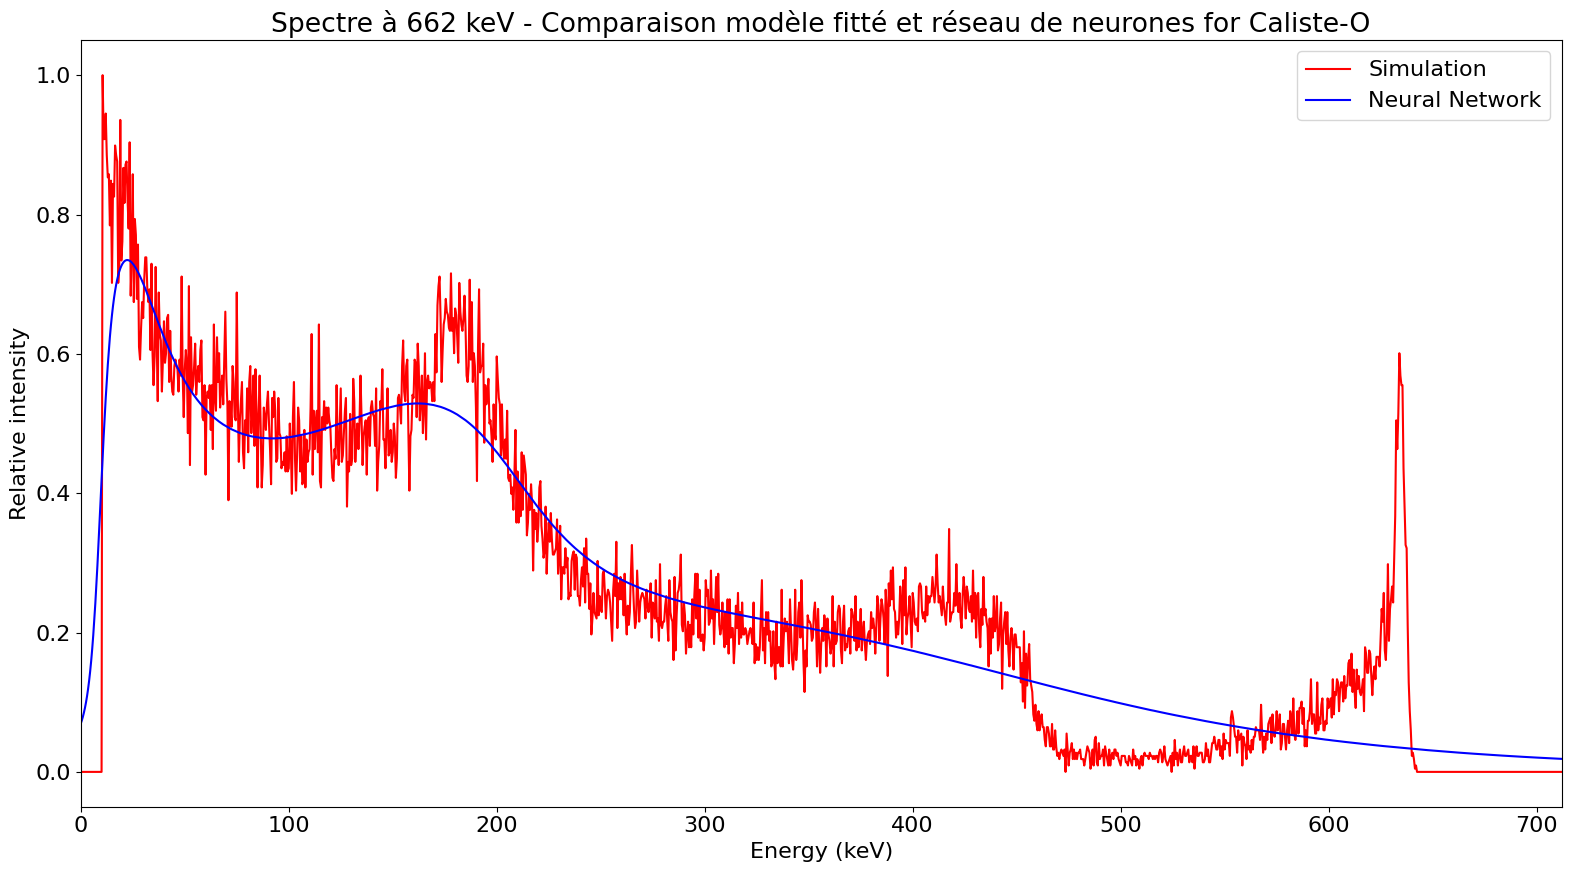

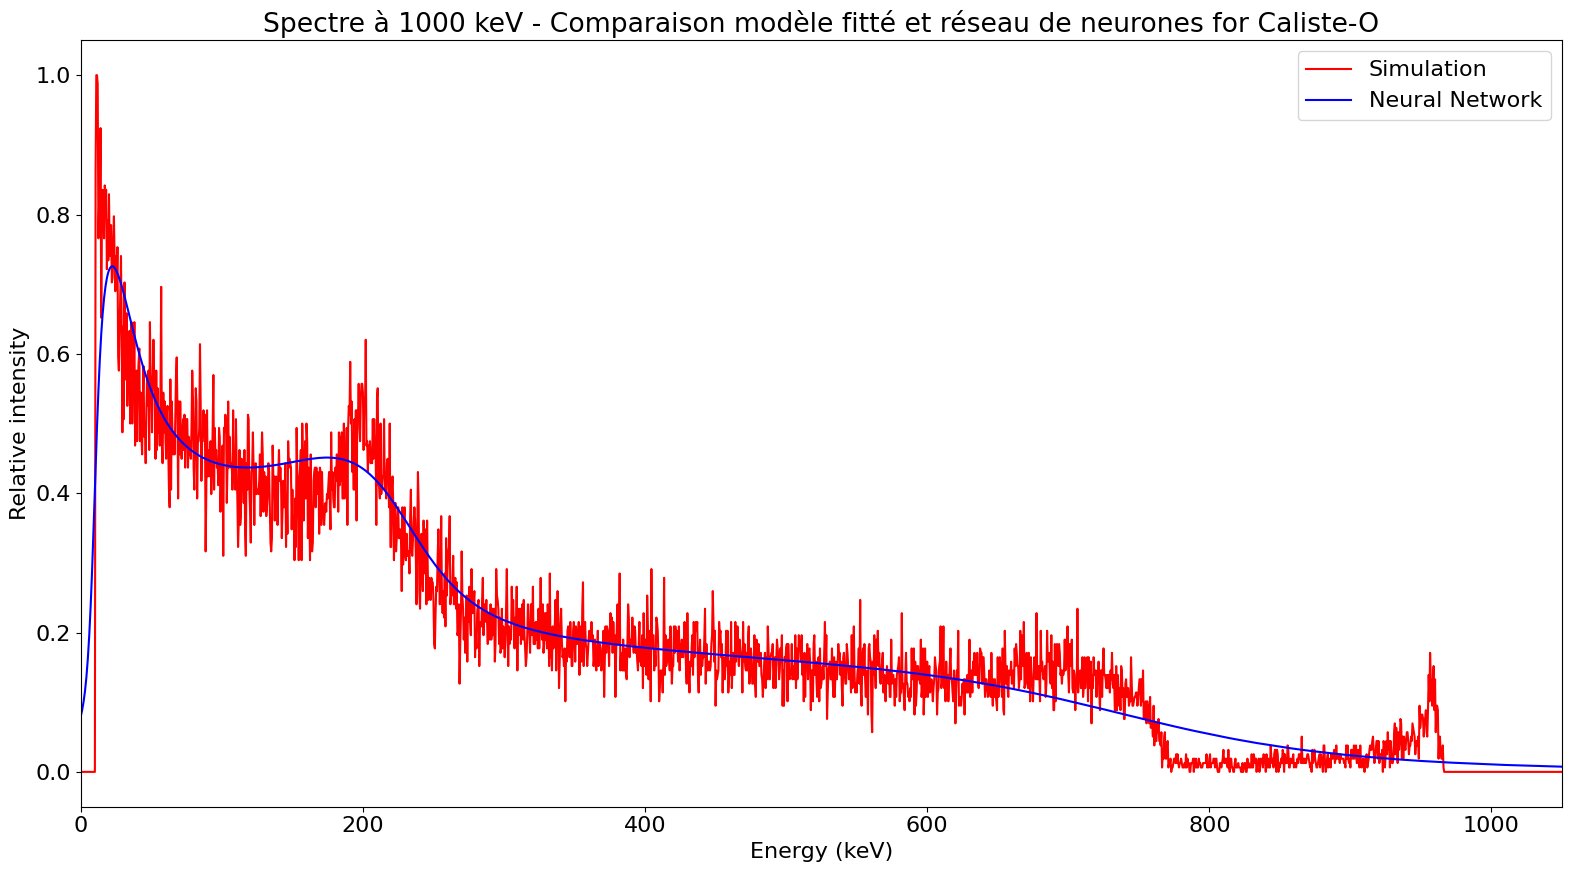

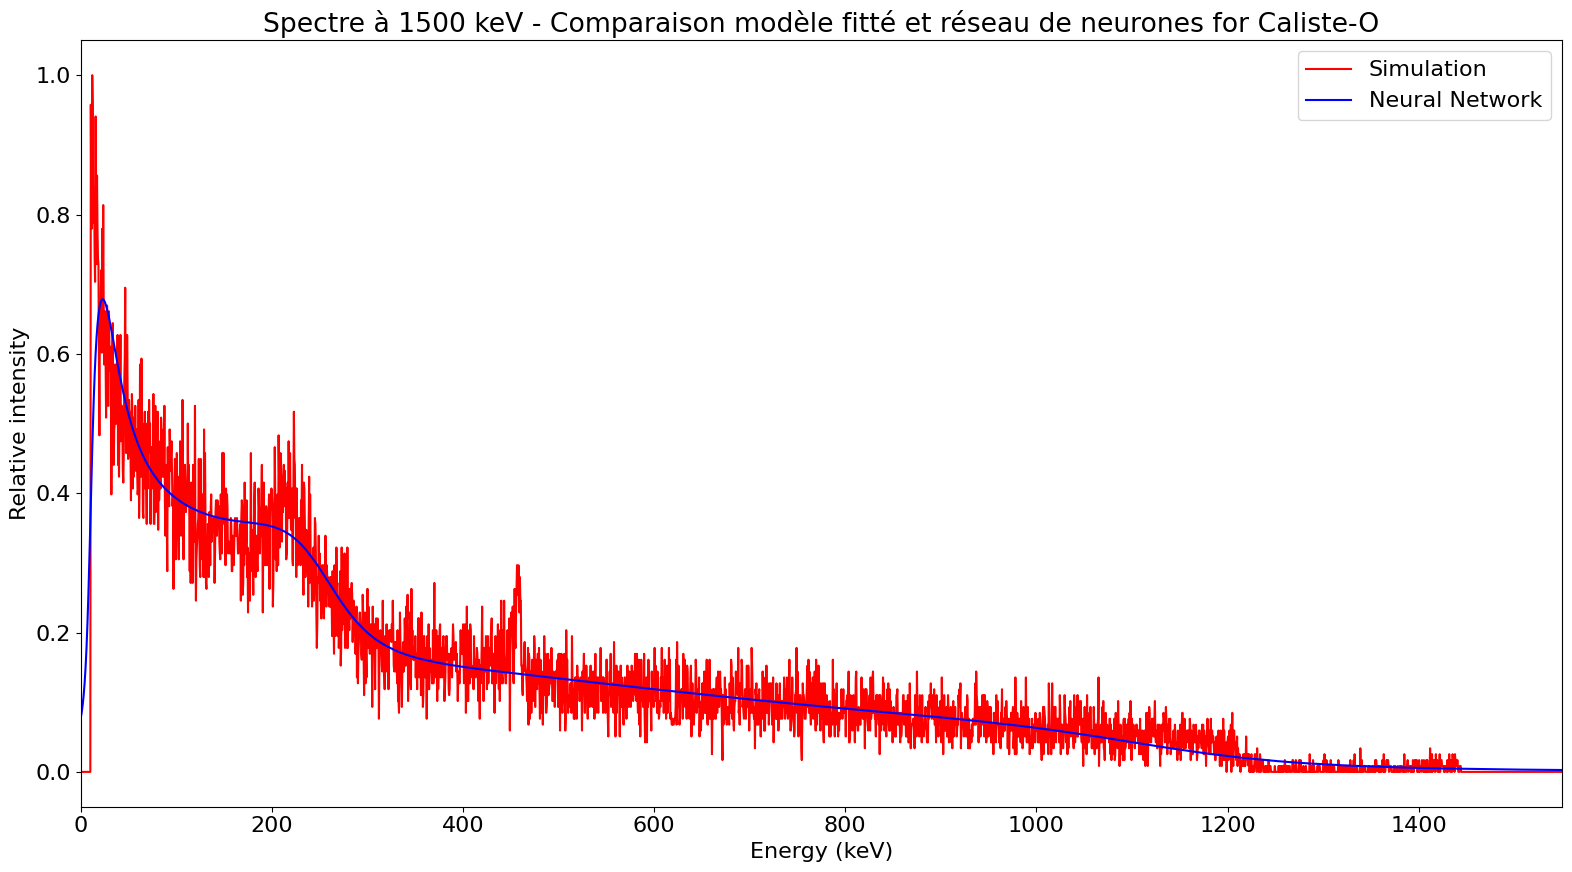

In [31]:
# energy_test = 662.
energies_to_test = (50, 100, 200, 300, 400, 500, 662, 1000, 1500)


for energy_test in energies_to_test:
    test_vector = np.zeros((varv.RESPONSE_MATRIX_DIM, 2))

    test_vector[:, 0] = test_vector[:, 0] + energy_test
    test_vector[:, 1] = np.arange(varv.RESPONSE_MATRIX_DIM)/2

    y_test = tf.constant(test_vector/2000)

    gen_spectrum =nn.model.predict(y_test)


    # plt.plot(np.arange(2000)/2,train_images[3])

    plt.rcParams.update({"font.size": 16})
    plt.figure(figsize=(16, 9))
    plt.plot(np.arange(varv.RESPONSE_MATRIX_DIM)/2,
            response_matrix_norm[int(energy_test*2)], label="Simulation", color="red")
    plt.plot(np.arange(varv.RESPONSE_MATRIX_DIM)/2, gen_spectrum[:, 0], label="Neural Network", color="blue")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Relative intensity")
    plt.title(
        f"Spectre à {energy_test} keV - Comparaison modèle fitté et réseau de neurones for Caliste-O")
    plt.legend()
    plt.xlim(0,50+ energy_test)
    plt.tight_layout()
    plt.savefig(f"{varv.PATH_FIGURES}detector_response_corrected_{energy_test}kev.png")
# plt.yscale("log")

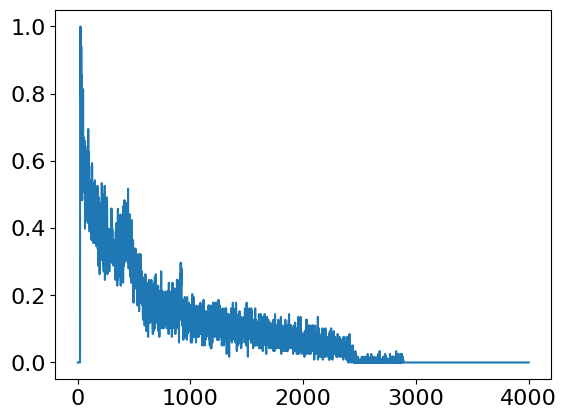

In [33]:
plt.plot(response_matrix_norm[int(energy_test*2)])

In [34]:
s = response_matrix_norm[int(energy_test*2)]